In [1]:
from xpipeline.tasks import improc, characterization

# Establishing the axis and rotation conventions in xpipeline

In [2]:
bpicdata = np.load('../xpipeline/ref/naco_betapic_preproc_absil2013_gonzalez2017.npz')

In [6]:
list(bpicdata)

['_vip_version',
 '_vip_object',
 'cube',
 'psf',
 'psfn',
 'angles',
 'fwhm',
 '_item_fwhm',
 'wavelengths',
 '_item_wavelengths',
 'px_scale',
 '_item_px_scale',
 'cuberef',
 '_item_cuberef']

In [42]:
angles = bpicdata['angles']
cube = bpicdata['cube']
psf = bpicdata['psf']

In [13]:
f_test = improc.f_test(128)

As a reminder, matplotlib defaults to showing (0, 0) at upper left, using the viridis colormap.

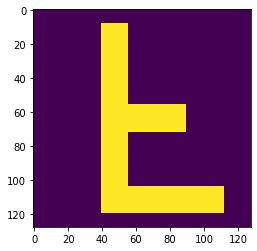

In [23]:
plt.imshow(f_test, cmap='viridis', origin='upper')

### Always use `origin='lower'`!
Ensure we never forget by using our own wrapper

In [24]:
def imshow(arr, *args, **kwargs):
    if 'origin' not in kwargs:
        kwargs['origin'] = 'lower'
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray'
    plt.imshow(arr, *args, **kwargs)

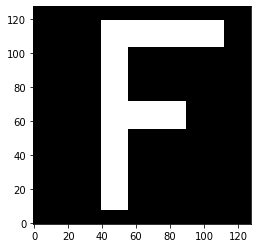

In [25]:
imshow(f_test)

We're frequently aligned to the star, so it would be more useful to have (0, 0) at the center.

In [26]:
def imshow(arr, *args, **kwargs):
    ny, nx = arr.shape
    if 'origin' not in kwargs:
        kwargs['origin'] = 'lower'
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray'
    if 'extent' not in kwargs:
        kwargs['extent'] = [-(nx - 1)/2, (nx - 1)/2, -(ny - 1)/2, (ny - 1)/2]
    plt.imshow(arr, *args, **kwargs)

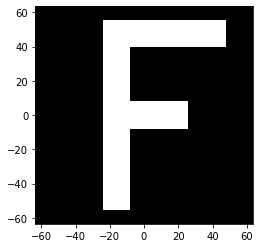

In [29]:
imshow(f_test)

Astronomers measure angles conventionally from a North-up, East-left coordinate frame where angle increases counterclockwise "East of North". In other words, a 10 arcsec separation at position angle of 0º will be directly above the reference point (+Y, when Y increases towards the top of the image, as is usual in astronomy).

xpipeline's rotation function takes, as an argument, the number of degrees to rotate counter-clockwise / E of N.

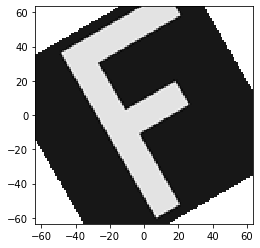

In [37]:
rot_f_deg = 30
rot_f = improc.rotate(f_test, rot_f_deg)
imshow(rot_f)

Convenience functions in `characterization` translate between x, y and r, PA with these conventions.

In [38]:
characterization.r_pa_to_x_y(25, 0, 0, 0)

(1.5308084989341915e-15, 25.0)

In [39]:
characterization.x_y_to_r_pa(0, 25, 0, 0)

(25.0, 0.0)

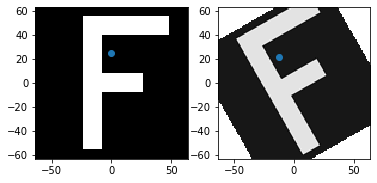

In [41]:
plt.subplot(121)
imshow(f_test)
plt.scatter(*characterization.r_pa_to_x_y(25, 0, 0, 0))
plt.subplot(122)
imshow(rot_f)
plt.scatter(*characterization.r_pa_to_x_y(25, rot_f_deg, 0, 0))

# PSF cube generation

Be careful when generating a PSF cube. Here we will use the dimensions of the beta Pic b data to generate a model cube.

In [48]:
model_cube = characterization.generate_signals(
    cube.shape,
    [characterization.CompanionSpec(r_px=25, pa_deg=0, scale=1)],
    psf,
    angles=angles
)

Check the last angle given (because it's easier to see):

In [52]:
angles[-1]

67.098564

Based on its value, and the PA of 0º passed in, we expect the first frame of the model cube to have a PSF centered at (r, PA) = (0, -67º). That way, when rotated by `angles[-1]` to place North-up East-left, the PSF will be in the +Y direction from the center of the image.

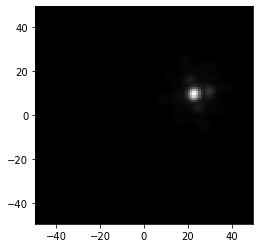

In [54]:
imshow(model_cube[-1])

There is a helper for using these angles to place N up E left: `improc.derotate_cube`:

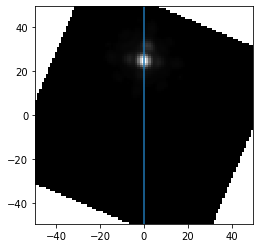

In [57]:
model_derotated = improc.derotate_cube(model_cube, angles)
imshow(model_derotated[-1])
plt.axvline(0)

Don't just take my word for it. For data obeying these conventions that contains a real planet, we should recover it.

In [58]:
cube_derotated = improc.derotate_cube(cube - np.median(cube, axis=0), angles)

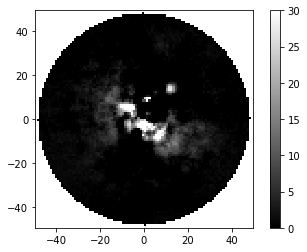

In [61]:
imshow(np.median(cube_derotated, axis=0), vmin=0, vmax=30)
plt.colorbar()